In [1]:
import numpy as np
import os, sys
import importlib
from tqdm.notebook import tqdm, trange
import pandas as pd
import json
import itertools
from IPython.display import display, HTML, clear_output
import matplotlib.pyplot as plt
%matplotlib inline

from FewShotTestHandler import FewShotTestHandler, optimize_hyperparameters, find_hyperparameters, dataframe_format
from dataset import DatasetHandler
from similarity_metrics import Similarity
from plotting_utils import plot

ENV = os.environ["CONDA_DEFAULT_ENV"]
pd.options.display.max_rows = 200

/home/rob/vlm_benchmark/FewShotTestHandler.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
!pip install scikit-optimize
import skopt
import skopt.plots

### Settings

In [3]:
# VLM Params - vlm.____ keys are passed into VLM constructor
if ENV == "VLM_CLIP":
    from CLIP.CLIPVLM import ClipVLM as VLM
    vlm = VLM(num_frames=10)
elif ENV == "VLM_MILES":
    from MILES.wrapper import MILES_SimilarityVLM as VLM
    vlm = VLM()
elif ENV == "videoclip":
    from video_clip.video_clip import VideoClipVLM as VLM
    vlm = VLM(num_seconds=4, sample_strat="spread", use_cuda=True)
elif ENV == "VLM_UNIVL":
    from UNIVL.wrapper import UniVL_SimilarityVLM as VLM
    vlm = VLM()
elif ENV == "VLM_VTTWINS":
    from VTTWINS.wrapper import VTTWINS_SimilarityVLM as VLM
    vlm = VLM()
else:
    raise NotImplementedError

PATH IS: video_clip/MMPT_updated/projects/retri/videoclip/how2.yaml
CKPT SAVE DIR: video_clip/MMPT_updated/runs/retri/videoclip


Some weights of the model checkpoint at bert-base-uncased were not used when initializing MMBertForEncoder: ['bert.encoder.layer.7.attention.self.key.weight', 'bert.encoder.layer.8.output.LayerNorm.weight', 'bert.encoder.layer.6.attention.self.value.weight', 'bert.encoder.layer.9.attention.self.value.weight', 'bert.encoder.layer.9.attention.output.dense.weight', 'bert.encoder.layer.9.attention.self.key.bias', 'bert.encoder.layer.6.attention.self.value.bias', 'bert.encoder.layer.9.attention.self.query.bias', 'bert.encoder.layer.10.attention.output.LayerNorm.weight', 'bert.encoder.layer.7.attention.self.query.bias', 'bert.encoder.layer.8.attention.output.LayerNorm.weight', 'bert.encoder.layer.11.attention.output.dense.weight', 'bert.encoder.layer.6.output.dense.weight', 'bert.encoder.layer.6.intermediate.dense.bias', 'bert.encoder.layer.10.attention.output.dense.weight', 'bert.encoder.layer.10.attention.output.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.bias', 'bert.encoder.lay

In [4]:
if False:
    from classifier import TipAdapterFewShotClassifier as Classifier
    HYPERPARAM_SPACE = [
        skopt.space.Real(0.1, 1000, name="alpha", prior="log-uniform"),
        skopt.space.Real(0.1, 100, name="beta", prior="log-uniform"),
        skopt.space.Real(1e-5, 1e-1, name="finetune_lr", prior="log-uniform"),
        skopt.space.Integer(0, 30, name="finetune_epochs"),
        skopt.space.Real(1e-4, 1, name="weight_decay", prior="log-uniform")
    ]
if True:
    from classifier.coop import CoopFewShotClassifier as Classifier
    HYPERPARAM_SPACE = [
        skopt.space.Real(1e-5, 1e-1, name="lr", prior="log-uniform"),
        #skopt.space.Integer(8, 32, name="context_len"),
        skopt.space.Integer(0, 1, name="random_augment"),
        skopt.space.Integer(5, 30, name="epochs"),
        skopt.space.Integer(1, 8, name="batch_size")
    ]

In [5]:
DATASET = "smsm"
query_dataset = DatasetHandler(DATASET, "val")
support_dataset = DatasetHandler(DATASET, "train")
query_dataset.fill_cache(vlm)
#support_dataset.fill_cache(vlm)

N_WAY = 100
N_SUPPORT_LIST = [4] #[0, 1, 2, 4, 8, 16, 32, 64]
N_QUERY = None
N_EPISODES = 4

TESTHANDLER_RESULTS_FILE = f"TEMP.hyperparam_search.{query_dataset.id()}.csv"
test_handler = FewShotTestHandler(TESTHANDLER_RESULTS_FILE)

SKOPT_RESULTS_FILE = f"TEMP.hyperparam_search.{vlm.__class__.__name__}.{query_dataset.id()}.{'_'.join([str(x) for x in N_SUPPORT_LIST])}_shot.pkl"
SKOPT_N_CALLS = 1000

  0%|          | 0/1100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

### Run SKOPT Hyperparameter Search

In [6]:
@skopt.utils.use_named_args(HYPERPARAM_SPACE)
def val_neg_accuracy(**classifier_params):
    classifier_params = dict(classifier_params)
    
    classifier = Classifier(vlm, **classifier_params)
    
    accuracies = []
    for n_support in N_SUPPORT_LIST:
        test_handler.run_few_shot_test(classifier, query_dataset, support_dataset, N_WAY, n_support, N_QUERY, N_EPISODES)

        # Find dataframe row with accuracy from this run
        filter_indices = np.ones(len(test_handler.results))
        for key, val in dataframe_format(classifier, query_dataset, support_dataset, N_WAY, n_support, N_QUERY, N_EPISODES).items():
            if pd.isna(val):
                filter_indices = filter_indices & pd.isna(test_handler.results[key])
            else:
                filter_indices = filter_indices & (test_handler.results[key] == val)
        matched_row = test_handler.results[filter_indices]
        accuracies.append(matched_row["accuracy"].values[0])
        
    return -1 * np.mean(accuracies)

skopt_pbar = None
def callback(current_skopt_results):
    skopt.dump(current_skopt_results, SKOPT_RESULTS_FILE)
    
    best_run_ind = np.argmin(current_skopt_results.func_vals)
    postfix_dict = {
        "best_acc": round(-1 * current_skopt_results.func_vals[best_run_ind], 5)
    }
    postfix_dict.update({
        param_space.name: round(current_skopt_results.x_iters[best_run_ind][i], 5)
        for i, param_space in enumerate(HYPERPARAM_SPACE)
    })
    skopt_pbar.update(1)
    skopt_pbar.set_postfix(postfix_dict)



if os.path.exists(SKOPT_RESULTS_FILE):
    old_skopt_results = skopt.load(SKOPT_RESULTS_FILE)
    x0 = old_skopt_results.x_iters
    y0 = old_skopt_results.func_vals
else:
    x0 = None
    y0 = None
skopt_pbar = tqdm(total=SKOPT_N_CALLS) 
skopt_results = skopt.gp_minimize(val_neg_accuracy, HYPERPARAM_SPACE, n_calls=SKOPT_N_CALLS, callback=callback, x0=x0, y0=y0)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/home/rob/miniconda3/envs/videoclip/lib/python3.8/site-packages/transformers/modeling_utils.py:713: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/rob/miniconda3/envs/videoclip/lib/python3.8/site-packages/torchvision/transforms/functional_tensor.py:892: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  step = nonzero_hist[:-1].sum() // 255
/home/rob/miniconda3/envs/videoclip/lib/python3.8/site-packages/torchvision/transforms/functional_tensor.py:896: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc

Epoch     0: Acc = 0.025, Loss = 4.602
Epoch     1: Acc = 0.020, Loss = 4.617
Epoch     2: Acc = 0.022, Loss = 4.585
Epoch     3: Acc = 0.018, Loss = 4.579
Epoch     4: Acc = 0.018, Loss = 4.529
Epoch     5: Acc = 0.030, Loss = 4.527
Epoch     6: Acc = 0.025, Loss = 4.527
Epoch     7: Acc = 0.030, Loss = 4.506
Epoch     8: Acc = 0.037, Loss = 4.486
Epoch     9: Acc = 0.020, Loss = 4.488
Epoch    10: Acc = 0.027, Loss = 4.494
Epoch    11: Acc = 0.043, Loss = 4.504
Epoch    12: Acc = 0.015, Loss = 4.477
Epoch    13: Acc = 0.020, Loss = 4.480
Epoch    14: Acc = 0.040, Loss = 4.440
Epoch    15: Acc = 0.035, Loss = 4.455
Epoch    16: Acc = 0.055, Loss = 4.436
Epoch    17: Acc = 0.030, Loss = 4.481
Epoch     0: Acc = 0.027, Loss = 4.595
Epoch     1: Acc = 0.030, Loss = 4.631
Epoch     2: Acc = 0.030, Loss = 4.555
Epoch     3: Acc = 0.047, Loss = 4.498
Epoch     4: Acc = 0.027, Loss = 4.515
Epoch     5: Acc = 0.043, Loss = 4.499
Epoch     6: Acc = 0.032, Loss = 4.501
Epoch     7: Acc = 0.052,

  0%|          | 0/4 [00:00<?, ?it/s]

/home/rob/miniconda3/envs/videoclip/lib/python3.8/site-packages/transformers/modeling_utils.py:713: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/rob/miniconda3/envs/videoclip/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch     0: Acc = 0.032, Loss = 4.523
Epoch     1: Acc = 0.032, Loss = 4.521
Epoch     2: Acc = 0.030, Loss = 4.519
Epoch     3: Acc = 0.030, Loss = 4.516
Epoch     4: Acc = 0.035, Loss = 4.514
Epoch     5: Acc = 0.035, Loss = 4.512
Epoch     6: Acc = 0.035, Loss = 4.510
Epoch     7: Acc = 0.035, Loss = 4.509
Epoch     8: Acc = 0.035, Loss = 4.507
Epoch     9: Acc = 0.035, Loss = 4.507
Epoch    10: Acc = 0.035, Loss = 4.506
Epoch    11: Acc = 0.035, Loss = 4.506
Epoch    12: Acc = 0.035, Loss = 4.506
Epoch     0: Acc = 0.032, Loss = 4.551
Epoch     1: Acc = 0.035, Loss = 4.548
Epoch     2: Acc = 0.037, Loss = 4.544
Epoch     3: Acc = 0.037, Loss = 4.539
Epoch     4: Acc = 0.037, Loss = 4.535
Epoch     5: Acc = 0.037, Loss = 4.532
Epoch     6: Acc = 0.035, Loss = 4.528
Epoch     7: Acc = 0.035, Loss = 4.526
Epoch     8: Acc = 0.037, Loss = 4.524
Epoch     9: Acc = 0.037, Loss = 4.523
Epoch    10: Acc = 0.037, Loss = 4.522
Epoch    11: Acc = 0.037, Loss = 4.521
Epoch    12: Acc = 0.037,

  0%|          | 0/4 [00:00<?, ?it/s]

/home/rob/miniconda3/envs/videoclip/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch     0: Acc = 0.040, Loss = 4.493
Epoch     1: Acc = 0.037, Loss = 4.448
Epoch     2: Acc = 0.067, Loss = 4.354
Epoch     3: Acc = 0.065, Loss = 4.297
Epoch     4: Acc = 0.065, Loss = 4.253
Epoch     5: Acc = 0.065, Loss = 4.209
Epoch     6: Acc = 0.062, Loss = 4.165
Epoch     7: Acc = 0.057, Loss = 4.121
Epoch     8: Acc = 0.065, Loss = 4.075
Epoch     9: Acc = 0.067, Loss = 4.031
Epoch    10: Acc = 0.078, Loss = 3.991
Epoch    11: Acc = 0.082, Loss = 3.957
Epoch    12: Acc = 0.090, Loss = 3.928
Epoch    13: Acc = 0.095, Loss = 3.905
Epoch    14: Acc = 0.093, Loss = 3.890
Epoch    15: Acc = 0.100, Loss = 3.882
Epoch     0: Acc = 0.037, Loss = 4.517
Epoch     1: Acc = 0.045, Loss = 4.483
Epoch     2: Acc = 0.037, Loss = 4.411
Epoch     3: Acc = 0.045, Loss = 4.366
Epoch     4: Acc = 0.052, Loss = 4.327
Epoch     5: Acc = 0.070, Loss = 4.286
Epoch     6: Acc = 0.082, Loss = 4.242
Epoch     7: Acc = 0.075, Loss = 4.198
Epoch     8: Acc = 0.085, Loss = 4.149
Epoch     9: Acc = 0.085,

  0%|          | 0/4 [00:00<?, ?it/s]

/home/rob/miniconda3/envs/videoclip/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch     0: Acc = 0.030, Loss = 4.519
Epoch     1: Acc = 0.052, Loss = 4.384
Epoch     2: Acc = 0.060, Loss = 4.261
Epoch     3: Acc = 0.070, Loss = 4.177
Epoch     4: Acc = 0.075, Loss = 4.106
Epoch     5: Acc = 0.090, Loss = 4.043
Epoch     6: Acc = 0.110, Loss = 3.949
Epoch     7: Acc = 0.122, Loss = 3.875
Epoch     8: Acc = 0.147, Loss = 3.803
Epoch     9: Acc = 0.165, Loss = 3.705
Epoch    10: Acc = 0.162, Loss = 3.599
Epoch    11: Acc = 0.170, Loss = 3.512
Epoch    12: Acc = 0.205, Loss = 3.422
Epoch    13: Acc = 0.240, Loss = 3.336
Epoch    14: Acc = 0.255, Loss = 3.266
Epoch    15: Acc = 0.265, Loss = 3.211
Epoch    16: Acc = 0.273, Loss = 3.176
Epoch     0: Acc = 0.040, Loss = 4.534
Epoch     1: Acc = 0.047, Loss = 4.421
Epoch     2: Acc = 0.062, Loss = 4.300
Epoch     3: Acc = 0.065, Loss = 4.229
Epoch     4: Acc = 0.067, Loss = 4.163
Epoch     5: Acc = 0.090, Loss = 4.099
Epoch     6: Acc = 0.100, Loss = 4.023
Epoch     7: Acc = 0.115, Loss = 3.957
Epoch     8: Acc = 0.120,

  0%|          | 0/4 [00:00<?, ?it/s]

/home/rob/miniconda3/envs/videoclip/lib/python3.8/site-packages/torchvision/transforms/functional_tensor.py:892: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  step = nonzero_hist[:-1].sum() // 255
/home/rob/miniconda3/envs/videoclip/lib/python3.8/site-packages/torchvision/transforms/functional_tensor.py:896: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, roundi

Epoch     0: Acc = 0.020, Loss = 4.601
Epoch     1: Acc = 0.010, Loss = 4.609
Epoch     2: Acc = 0.022, Loss = 4.582
Epoch     3: Acc = 0.035, Loss = 4.566
Epoch     4: Acc = 0.025, Loss = 4.541
Epoch     5: Acc = 0.025, Loss = 4.515
Epoch     6: Acc = 0.025, Loss = 4.532
Epoch     7: Acc = 0.027, Loss = 4.526
Epoch     8: Acc = 0.040, Loss = 4.470
Epoch     9: Acc = 0.025, Loss = 4.518
Epoch    10: Acc = 0.018, Loss = 4.577
Epoch    11: Acc = 0.030, Loss = 4.488
Epoch    12: Acc = 0.025, Loss = 4.505
Epoch    13: Acc = 0.037, Loss = 4.441
Epoch    14: Acc = 0.030, Loss = 4.488
Epoch     0: Acc = 0.020, Loss = 4.677
Epoch     1: Acc = 0.018, Loss = 4.615
Epoch     2: Acc = 0.025, Loss = 4.590
Epoch     3: Acc = 0.030, Loss = 4.546
Epoch     4: Acc = 0.022, Loss = 4.558
Epoch     5: Acc = 0.022, Loss = 4.547
Epoch     6: Acc = 0.020, Loss = 4.575
Epoch     7: Acc = 0.043, Loss = 4.530
Epoch     8: Acc = 0.032, Loss = 4.527
Epoch     9: Acc = 0.030, Loss = 4.547
Epoch    10: Acc = 0.040,

  0%|          | 0/4 [00:00<?, ?it/s]

/home/rob/miniconda3/envs/videoclip/lib/python3.8/site-packages/torchvision/transforms/functional_tensor.py:892: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  step = nonzero_hist[:-1].sum() // 255
/home/rob/miniconda3/envs/videoclip/lib/python3.8/site-packages/torchvision/transforms/functional_tensor.py:896: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, roundi

Epoch     0: Acc = 0.025, Loss = 4.612
Epoch     1: Acc = 0.010, Loss = 4.591
Epoch     2: Acc = 0.032, Loss = 4.527
Epoch     3: Acc = 0.035, Loss = 4.467
Epoch     4: Acc = 0.020, Loss = 4.483
Epoch     5: Acc = 0.045, Loss = 4.496
Epoch     6: Acc = 0.062, Loss = 4.446
Epoch     7: Acc = 0.040, Loss = 4.404
Epoch     8: Acc = 0.047, Loss = 4.396
Epoch     9: Acc = 0.045, Loss = 4.353
Epoch    10: Acc = 0.050, Loss = 4.347
Epoch     0: Acc = 0.010, Loss = 4.616
Epoch     1: Acc = 0.043, Loss = 4.583
Epoch     2: Acc = 0.015, Loss = 4.583
Epoch     3: Acc = 0.032, Loss = 4.556
Epoch     4: Acc = 0.030, Loss = 4.533
Epoch     5: Acc = 0.032, Loss = 4.487
Epoch     6: Acc = 0.047, Loss = 4.464
Epoch     7: Acc = 0.035, Loss = 4.483
Epoch     8: Acc = 0.040, Loss = 4.422
Epoch     9: Acc = 0.045, Loss = 4.429
Epoch    10: Acc = 0.015, Loss = 4.441
Epoch     0: Acc = 0.022, Loss = 4.645
Epoch     1: Acc = 0.020, Loss = 4.633
Epoch     2: Acc = 0.012, Loss = 4.570
Epoch     3: Acc = 0.045,

KeyboardInterrupt: 

### Plot Hyperparam Search Results

In [ ]:
skopt_results = skopt.load(SKOPT_RESULTS_FILE)

lr                   0.016751266149792866
random_augment       0


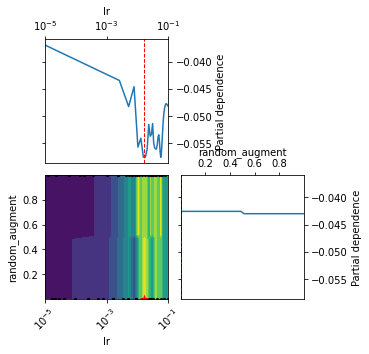

In [ ]:
skopt.plots.plot_objective(skopt_results)
for i, hyperparam in enumerate(HYPERPARAM_SPACE):
    print(f"{hyperparam.name:20} {skopt_results.x[i]}")

In [ ]:
averaged_over_support = test_handler.results.groupby([col for col in test_handler.results.columns if col not in ["n_support", "accuracy", "accuracy_std"]], as_index=False, dropna=False).mean()

# Drop any sets which didn't complete the full list of support values (if interrupted, etc)
averaged_over_support = averaged_over_support[averaged_over_support["n_support"] == np.mean(N_SUPPORT_LIST)]

for hyperparam in HYPERPARAM_SPACE:
    plt.scatter(averaged_over_support[f"classifier.{hyperparam.name}"].values, averaged_over_support["accuracy"].values)
    plt.ylabel("accuracy")
    plt.xlabel(hyperparam.name)
    plt.title(hyperparam.name)
    plt.show()

NameError: name 'N_SUPPORT_LIST' is not defined